# Tobit

In [1]:
import numpy as np
import pandas as pd 
from numpy import linalg as la
from scipy.stats import norm
from scipy import optimize
from tabulate import tabulate
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set_theme()

%load_ext autoreload
%autoreload 2

import tobit_ante as tobit
import estimation
import LinearModels as lm

## Question 1: Simulate Data

1. Fill out `tobit.sim_data(theta,N)` and simulate a dataset
2. Fill out `tobit.predict(theta, x)`, returning `E, Epos`: 
$$
\begin{align}
\mathbb{E}(y_{i}|\mathbf{x}_{i})	&=	\mathbf{x}_{i}\beta\Phi\left(\frac{\mathbf{x}_{i}\beta}{\sigma}\right)+\sigma\phi\left(\frac{\mathbf{x}_{i}\beta}{\sigma}\right),
\\
\mathbb{E}(y_{i}|\mathbf{x}_{i},y_{i}>0)	&=	\mathbf{x}_{i}\beta+\sigma\underbrace{\lambda}_{\texttt{Mill's Ratio}}\left(\frac{\mathbf{x}_{i}\beta}{\sigma}\right).
\end{align}
$$

In [2]:
N = 1000
betao = np.array([1.,1.])
sigo = 1.
thetao = np.append(betao, sigo) # since sigo is scalar, use np.append() rather than np.stack

In [3]:
np.random.seed(1)
y,x = tobit.sim_data(thetao, N)

In [4]:
E, Epos = tobit.predict(thetao, x)

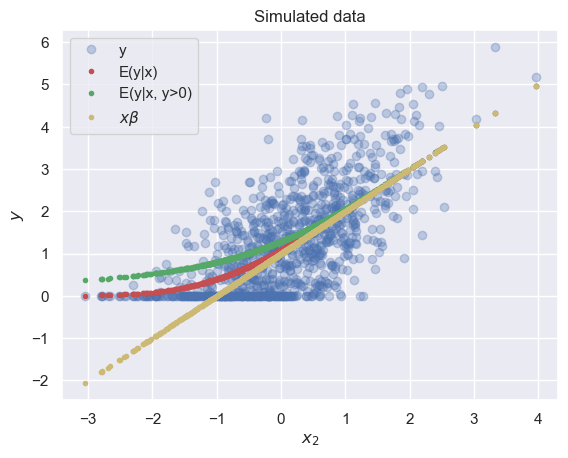

In [5]:
fig,ax = plt.subplots();
ax.plot(x[:, 1], y, 'o', alpha=0.3, label='y');
ax.plot(x[:, 1], E,    '.r', label='E(y|x)')
ax.plot(x[:, 1], Epos, '.g', label='E(y|x, y>0)')
ax.plot(x[:, 1], x@betao,  '.y', label='$x \\beta$')
ax.set_title('Simulated data'); ax.set_xlabel('$x_2$'); ax.set_ylabel('$y$');
ax.legend();

## Question 2: Estimate Tobit Model

1. Fill out `tobit.starting_values(y,x)`: base starting values of $\boldsymbol{\theta} = (\boldsymbol{\beta}, \sigma)$ on OLS counterparts; even though they are inconsistent, they are somewhat in the ballpark. Note that we will be estimating $\sigma$ and not $\sigma^2$.  
2. Finish writing the criterion function, `q(theta, y, x)` based on `loglikelihood(theta, y, x)`, in the `tobit.py` based on the likelihood function $$ 
\ell_i(\theta) = \mathbf{1}\{y_i = 0\} \log\left[1 - \Phi\left(\frac{\mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] 
               + \mathbf{1}\{y_i > 0\} \log\left[\frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] $$
3. Estimate the model on simulated data

***Hints:***
* For the normal CDF and PDF: Use `norm.cdf` and `norm.cdf` from `scipy.stats`
* Since you are taking logs, it can be good practice to ensure that you are not taking log of zero. Use `np.clip(vec, 1e-8, 1.0-1e-8)`, for example, to ensure that `vec` is within $[0.00000001; 0.99999999]$
* Force `sigma` to remain positive during estimation by taking `np.abs(sigma)` when unpacking parameters (in `loglikelihood`, e.g.)

You can check if you got the correct result below.

In [6]:
theta0 = tobit.starting_values(y, x)
theta0


array([1.22225581, 0.78971417, 0.87827126])

In [7]:
# call the loglikelihood function 
ll0 = tobit.loglikelihood(theta0, y, x)

# this can sometimes be off if your seed is not set or if your version is very different from 
# the one used by me (np.__version__ = 1.21.2)
np.isclose( np.mean(ll0), -1.3433337203403535 ) 

True

In [8]:
res = estimation.estimate(tobit.q, theta0, y, x, cov_type='Sandwich')

Optimization terminated successfully.
         Current function value: 1.288781
         Iterations: 7
         Function evaluations: 32
         Gradient evaluations: 8


Print results out in a neat table 

In [9]:
result_dict = {'theta_o': thetao, 
              'thetahat': res['theta'], 
              't': res['t']}
lab_theta = ['x1', 'x2', 'sigma']

pd.DataFrame(result_dict, index=lab_theta).round(3)

,theta_o,thetahat,t
x1,1.0,1.022,30.107
x2,1.0,1.035,28.312
sigma,1.0,1.029,42.137


Expected results: Final function value: 1.288781, Function evaluations: 32. 

|       |   theta_o |   thetahat |      t |
|:------|----------:|-----------:|-------:|
| x1    |         1 |      1.022 | 30.107 |
| x2    |         1 |      1.035 | 28.312 |
| sigma |         1 |      1.029 | 42.137 |

Empirical analysis
==================

The exercise asks you to estimate a censored regression model for the
number of working hours in the labour market, using the `mroz_hours.txt`
dataset (same as PS04, with working hours). Working hours is a
left-censored variable because the variable hours takes the value zero
when no hours are put in the labour market. The data set
`mroz_hours.txt` contains observations on 753 women for the following
variables:

|*Variable*  | *Definition*|
|------------| ---------------------------------|
|`Hours`     | Number of hours worked annually|
|`Nwifeinc`  | Non wife income|
|`Educ`      | Years of education|
|`Exper`     | Experience in labour market|
|`Expersq`   | Experience squared|
|`Age`       | Age|
|`Kidslt6`   | Number of kids aged 0--5|
|`Kidsge6`   | Number of kids aged 6--18|

In [10]:
# some of the columns are not documented; we name them n.a. X
cols = ['hours', 'n.a. 1', 'nwifeinc', 'exper', 'expersq', 'age', 'kidslt6', 'kidsge6', 
        'n.a. 2', 'n.a. 3', 'n.a. 4', 'educ']

# read dataset 
dat = pd.read_csv('mroz_hours.txt', header = None, names = cols)

# add constant term 
dat['cnst'] = 1.0

# Declare labels
lbly = 'hours'
lblx = ['cnst', 'nwifeinc', 'educ', 'exper', 'expersq', 'age', 'kidslt6', 'kidsge6']

# pandas to numpy 
x = dat[lblx].values
y = dat[lbly].values

## Question 3: distribution of hours worked
As a preperation, plot y in a histogram. Does the distribution of hours worked look problematic?

In [11]:
# The matbplotlib.pyplot module is already loaded for you as plt.
# A hint is to use more bins than default, try for example 50 bins.
# FILL IN: Plot a histogram of y.

The distribution of hours look problematic in the sense that a lot of people work zero hours - truncated 

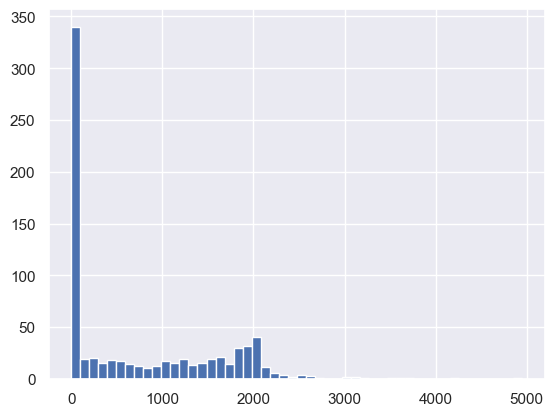

In [12]:
plt.hist(y, bins=50, color='b')
plt.show()

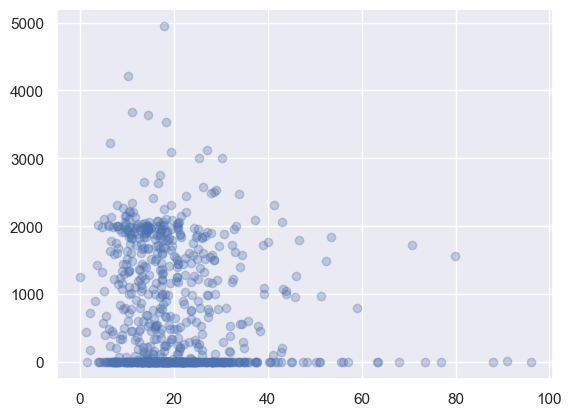

In [13]:
fig,ax = plt.subplots();
ax.plot(x[:, 1], y, 'o', alpha=0.3, label='y');

## Question 4: OLS

Estimate by OLS a regression function of annual hours worked as a function of the variables (`cnst`, `nwifeinc, educ, exper, expersq, age, kidslt6, kidsge6`), using the `LinearModels` module. 

Check that your `tobit.starting_values()` function is getting the correct numbers in creating `theta0`: The first $K=8$ parameters are $\boldsymbol{\beta}$, and the last, 9th coefficient is $\sigma$ (and not $\sigma^2$!). 

In [14]:
res_ols = lm.estimate(y,x)

b = lm.est_ols(y,x) 
N,K= x.shape
sig = np.sqrt(res_ols['sigma2'])
theta0 = np.append(b, sig) # the structure of theta0 
theta0

array([ 1.33048240e+03, -3.44663566e+00,  2.87611247e+01,  6.56725132e+01,
       -7.00493924e-01, -3.05116345e+01, -4.42089908e+02, -3.27792265e+01,
        7.50178608e+02])

In [15]:
ols_results = lm.estimate(y.reshape(-1,1), x)

In [16]:
ols_results

{'b_hat': array([[ 1.33048240e+03],
        [-3.44663566e+00],
        [ 2.87611247e+01],
        [ 6.56725132e+01],
        [-7.00493924e-01],
        [-3.05116345e+01],
        [-4.42089908e+02],
        [-3.27792265e+01]]),
 'se': array([[273.41349357],
        [  2.22872732],
        [ 12.96960165],
        [ 10.73669646],
        [  0.37003148],
        [  4.22218196],
        [ 57.15776719],
        [ 22.68093052]]),
 'sigma2': array([[562767.94351536]]),
 't_values': array([[ 4.86619143],
        [-1.5464591 ],
        [ 2.21757965],
        [ 6.11664057],
        [-1.89306576],
        [-7.22650865],
        [-7.73455524],
        [-1.44523288]]),
 'R2': array([[0.26562449]]),
 'cov': array([[ 7.47549385e+04,  8.69923515e+01, -2.19555122e+03,
         -4.38423633e+02,  1.54017075e+01, -9.76989086e+02,
         -7.31280379e+03, -2.57150652e+03],
        [ 8.69923515e+01,  4.96722549e+00, -1.05610425e+01,
          2.73855686e+00, -2.86733236e-02, -1.82963426e+00,
         -9.158

In [17]:
d = {'betahat': ols_results['b_hat'].flatten(), # <- put betahat here 
     'se': ols_results['se'].flatten() # <- put standard errors here (make sure they are flattened)
    }
tab = pd.DataFrame(d, index=lblx)
tab = pd.concat([tab,pd.DataFrame({'betahat': sig**2, 'se': np.nan}, index=['sigma'])])
tab

,betahat,se
cnst,1330.482400,273.413494
nwifeinc,-3.446636,2.228727
educ,28.761125,12.969602
exper,65.672513,10.736696
expersq,-0.700494,0.370031
age,-30.511634,4.222182
kidslt6,-442.089908,57.157767
kidsge6,-32.779226,22.680931
sigma,562767.943515,NaN


In [18]:
lm.print_table((lbly, lblx), ols_results)

Results
Dependent variable: hours

                 Beta          Se    t-values
--------  -----------  ----------  ----------
cnst      1330.48      273.413        4.86619
nwifeinc    -3.44664     2.22873     -1.54646
educ        28.7611     12.9696       2.21758
exper       65.6725     10.7367       6.11664
expersq     -0.700494    0.370031    -1.89307
age        -30.5116      4.22218     -7.22651
kidslt6   -442.09       57.1578      -7.73456
kidsge6    -32.7792     22.6809      -1.44523
R² = 0.266
σ² = 562767.944


c:\Users\JBH\anaconda3\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


You should get 

Results
Dependent variable: hours


|              |   beta  |       se  |       t |
|-------------:|--------:|---------:|--------:|
|         cnst | 1330.48 | 273.413  | 4.86619 |
|     nwifeinc |-3.44664 | 2.22873  |-1.54646 |
|         educ | 28.7611 | 12.9696  | 2.21758 |
|        exper | 65.6725 | 10.7367  | 6.11664 |
|      expersq |-0.70049 | 0.370031 |-1.89307 |
|         age  |-30.5116 | 4.22218  |-7.22651 |
|     kidslt6  | -442.09 | 57.1578  |-7.73456 |
|     kidsge6  |-32.7792 | 22.6809  |-1.44523 |
R² = 0.266
σ² = 562767.944

## Question 5: Tobit model on actual data
1. If you haven't already, finish writing the criterion function, in the `tobit.py` based on the likelihood function $$ 
\ell_i(\theta) = \mathbf{1}\{y_i = 0\} \log\left[1 - \Phi\left(\frac{\mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] 
               + \mathbf{1}\{y_i > 0\} \log\left[\frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{x}_i \boldsymbol{\beta}}{\sigma}\right)\right] $$
2. Estimate the model 

***Hints:***
* For the normal CDF and PDF: Use `norm.cdf` and `norm.cdf` from `scipy.stats`
* Since you are taking logs, it can be good practice to ensure that you are not taking log of zero. Use `np.clip(vec, 1e-8, 1.0-1e-8)`, for example, to ensure that `vec` is within $[0.00000001; 0.99999999]$
* Force `sigma` to remain positive during estimation by taking `np.abs(sigma)` when unpacking parameters. 

You can check if you got the correct result below.

In [19]:
np.isclose(
    np.mean(tobit.loglikelihood(theta0, y, x))
    , -5.257462977706353
)
np.mean(tobit.loglikelihood(theta0, y, x))

-5.257462977706347

## Question 6: Estimate Tobit Model on Actual Data
Estimate the corresponding Censored Regression Model by Maximum Likelihood. To do this, $\texttt{[FILL IN]}$ the blanks in the `q` function in the `tobit` class and supply it to the `estimation.estimate()` function.

Report also $\hat{\sigma}^{2}$ and $R_{\mathrm{Tobit}}^{2}$. 

In [20]:
result = estimation.estimate(tobit.q, theta0, y, x)

Optimization terminated successfully.
         Current function value: 5.072163
         Iterations: 135
         Function evaluations: 1400
         Gradient evaluations: 140


Optimization terminated successfully.
         Current function value: 5.072184
         Iterations: 125
         Function evaluations: 1310
         Gradient evaluations: 131

Calculate the $R_{\mathrm{Tobit}}^{2}$, this is the squared correlation between $y_{i}$ and $\hat{y}_{i}$, where $\hat{y}_i = \Phi (\mathbf{x}_i \hat{\beta}/\hat{\sigma})\mathbf{x}_i \hat{\beta} + \hat{\sigma}\phi(\mathbf{x}_i \hat{\beta}/\hat{\sigma})$, which is the estimate of $\mathrm{E}\left(y|\mathbf{x}=\mathbf{x}_{i}\right )$\] ($\Phi$ is the normal cdf, and $\phi$ is the normal pdf).

In [21]:
# Compute R2
sigma_tob = result.get('theta')[-1]
sig_tob   = result.get('theta')[-1]
b_tob     = result.get('theta')[:-1]
b_se_tob  = result.get('se')[:-1]

xb = x@b_tob
y_hat = xb*norm.cdf(xb/sigma_tob) + sigma_tob*norm.pdf(xb/sigma_tob)
rho = np.corrcoef(y.flatten(), y_hat.flatten())[0, 1]
R2_tob = rho*rho

In [22]:
tab = pd.DataFrame({'b_ols': theta0[:-1], 'b_tobit': b_tob, 'se': b_se_tob}, index=lblx)
tab = pd.concat([tab,pd.DataFrame({'b_ols': theta0[-1], 'b_tobit': sig_tob, 'se': result['se'][-1]}, index=['sigma'])])
tab = pd.concat([tab,pd.DataFrame({'b_ols': '', 'b_tobit': '', 'se': R2_tob}, index=['R2'])])

tab.round(2)

,b_ols,b_tobit,se
cnst,1330.4824,1276.861773,449.52
nwifeinc,-3.446636,-8.498695,4.41
educ,28.761125,71.597913,21.67
exper,65.672513,128.728935,16.22
expersq,-0.700494,-1.762927,0.50
age,-30.511634,-58.385169,7.84
kidslt6,-442.089908,-916.408963,112.25
kidsge6,-32.779226,-28.467359,38.81
sigma,750.178608,1121.502638,41.77
R2,,,0.28


Your table should look something like this:

Tobit Results <br>
Dependent variable: hours <br>


|          | b_ols   | b_tobit   |      se |
|:---------|:--------|:----------|--------:|
| cnst     | 1330.48 | 1277      | 450     |
| nwifeinc | -3.45   | -8.5      |  4.410  |
| educ     | 28.76   | 71.6      |  21.7   |
| exper    | 65.67   | 128.8     |  16.2   |
| expersq  | -0.7    | -1.76     |   0.50  |
| age      | -30.51  | -58.4     |   7.9   |
| kidslt6  | -442.09 | -918      | 112.3   |
| kidsge6  | -32.78  | -28.4     |  38.8   |
| sigma    | 750.18  | 1122      |  41.8   |
| R2       |         |           |   0.28  |

## Question 7: Marginal Effects
Calculate the two types of marginal effects, cf. eqs. (7) and (8), of taking an additional year of education evaluated at the mean values of the $\mathbf{x}$'s. Remember that $\lambda(\mathbf{x}\mathbf{\beta}/\sigma) \equiv \phi \left( \mathbf{x}\mathbf{\beta}/\sigma
\right) / \Phi \left( \mathbf{x}\mathbf{\beta}/\sigma \right)$ is called the inverse Mills ratio.
$$
\begin{align}
\frac{\partial \mathrm{E}\left( y|\mathbf{x},y>0\right) }{\partial x} 
&=\beta\Big\{ 1 - \lambda(\cdot) \big[ 
        \mathbf{x}\mathbf{\beta} / \sigma +\lambda(\cdot)
    \big] \Big\}. \tag{7} 
\end{align}
$$

$$
\begin{align}
\frac{\partial \mathrm{E}\left( y|\mathbf{x}\right) }{\partial x}
&= \beta \Phi\left(\frac{\mathbf{x}\mathbf{\beta}}{\sigma }\right), \tag{8}
\end{align}
$$

***Hints:***
* Note that `lambda` is a keyword in Python (used when defining an anonymous function) so you cannot create a variable by that name.
* For both marginal effects, the expression ends up being $\boldsymbol{\beta}$ ($K \times 1$) times something that is scalar (when evaluated at some $\mathbf{x} = \mathbf{x}^0$). However, later we may want to give as an input the full `x` matrix ($N \times K$), whereby the scalar becomes `(N,)` instead. Use `np.outer(beta, stuff)` to return an appropriate matrix in that case (it also works if `stuff` is scalar).


In [23]:
thetahat = result['theta']
b_tob = thetahat[:-1] # None # read in beta estimate 
sigma_tob = thetahat[-1] #None # and sigma estimate 

In [24]:
lblx[3]

'exper'

In [25]:
temp = pd.DataFrame(x, columns=lblx)
temp.head()

,cnst,nwifeinc,educ,exper,expersq,age,kidslt6,kidsge6
0,1.0,10.910060,12.0,14.0,196.0,32.0,1.0,0.0
1,1.0,19.499981,12.0,5.0,25.0,30.0,0.0,2.0
2,1.0,12.039910,12.0,15.0,225.0,35.0,1.0,3.0
3,1.0,6.799996,12.0,6.0,36.0,34.0,0.0,3.0
4,1.0,20.100058,14.0,7.0,49.0,31.0,1.0,2.0


In [26]:
index_exper = 3
index_exper_sq = 4
x0 = np.mean(x, axis=0) # evaluate at the mean of x variables 
x0[index_exper_sq] = x0[index_exper]*x0[index_exper]  # Square of mean, and not mean of square.

In [27]:
# It is convenient to write a function that takes a generic x as input
# 
def mills_ratio(z):
    return norm.pdf(z) / norm.cdf(z)

def marg_effect(x, b, sigma):  
    
    # Write up the marginal effect on E(y|x,y>0) using eq. (7). 
    # Note that the curly bracket gives you a scalar value, which you multiply on the beta vector
    # (you can use np.outer() or regular "*" multiplication, but np.outer() will generalize later)
    # Call this margeff_1

    xb_s = x@b/sigma

    phi = norm.pdf(xb_s)

    Phi = norm.cdf(xb_s)

    #margeff_1 = b*(1-mills_ratio(xb_s)*(xb_s+mills_ratio(xb_s)))

    margeff_1=np.outer(b,(1-mills_ratio(xb_s)*(xb_s+mills_ratio(xb_s))))

    # Write up the marginal effect on E(y|x) using eq. (8). 
    # Again, you multiply the beta vector on a scalar value. 
    # Call this margeff_2

    #margeff_2 = b*norm.cdf(xb_s)

    margeff_2 = np.outer(b, norm.cdf(xb_s))


    return margeff_1, margeff_2

In [28]:
# Calculate the marginal effect and print out the effect of education.
margeff_1, margeff_2 = marg_effect(x0, b_tob, sigma_tob)
table = [
    ['dE(y|x,y>0)/dx', margeff_1[2]], 
    ['dE(y|x)/dx', margeff_2[2]]
]
print('Marginal effect of an additional year of education from tobit model')
print(tabulate(table))

Marginal effect of an additional year of education from tobit model
--------------  -------
dE(y|x,y>0)/dx  32.3405
dE(y|x)/dx      46.1278
--------------  -------


c:\Users\JBH\anaconda3\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


In [29]:
# You should get results close to
margeff_1, margeff_2 = marg_effect(x0, b_tob, sigma_tob)
table = [
    ['dE(y|x,y>0)/dx', 32.35] , 
    ['dE(y|x)/dx', 46.14 ]
]
print('Marginal effect of an additional year of education from tobit model')
print(tabulate(table))

Marginal effect of an additional year of education from tobit model
--------------  -----
dE(y|x,y>0)/dx  32.35
dE(y|x)/dx      46.14
--------------  -----


## Question 8: Marginal Effect of Education
Calculate for all individuals the two types of marginal effects of taking an additional year of education. i) Draw a histogram of the marginal effect of education across individuals. ii) Make a scatter plot with educ along the x-axis and the marginal effect along the y-axis. Give an interpretation of your findings.

In [30]:
# If you have written the function correctly, we should be able to pass the whole x matrix thorugh the function.
margeff_all_1, margeff_all_2 = marg_effect(x, b_tob, sigma_tob)

In [31]:
me1 = pd.DataFrame(margeff_all_1.T, columns=lblx)
me2 = pd.DataFrame(margeff_all_2.T, columns=lblx)
# now you can use pandas functions like histograms (i.e. df.hist()) on the dataframes me1 and me2

---

Marginal effect of education, given that working hours are positive 

$$
dE(y|x,y>0)/dx
$$

array([[<AxesSubplot: title={'center': 'cnst'}>,
        <AxesSubplot: title={'center': 'nwifeinc'}>,
        <AxesSubplot: title={'center': 'educ'}>],
       [<AxesSubplot: title={'center': 'exper'}>,
        <AxesSubplot: title={'center': 'expersq'}>,
        <AxesSubplot: title={'center': 'age'}>],
       [<AxesSubplot: title={'center': 'kidslt6'}>,
        <AxesSubplot: title={'center': 'kidsge6'}>, <AxesSubplot: >]],
      dtype=object)

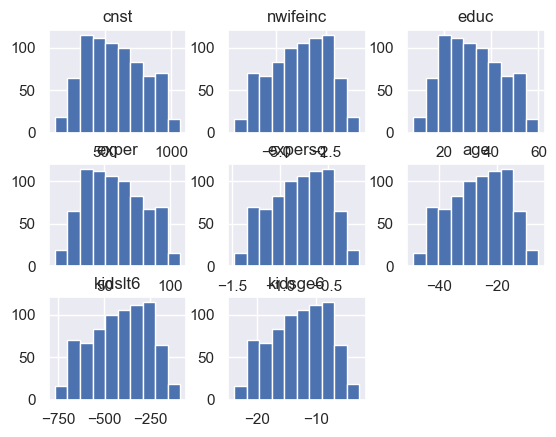

In [32]:
# Marginal effect of an extra year of education
me1.hist()

Marginal effect of education, unconditional of working hours (regardless of whether you work or not)

$$
dE(y|x)/dx
$$

array([[<AxesSubplot: title={'center': 'cnst'}>,
        <AxesSubplot: title={'center': 'nwifeinc'}>,
        <AxesSubplot: title={'center': 'educ'}>],
       [<AxesSubplot: title={'center': 'exper'}>,
        <AxesSubplot: title={'center': 'expersq'}>,
        <AxesSubplot: title={'center': 'age'}>],
       [<AxesSubplot: title={'center': 'kidslt6'}>,
        <AxesSubplot: title={'center': 'kidsge6'}>, <AxesSubplot: >]],
      dtype=object)

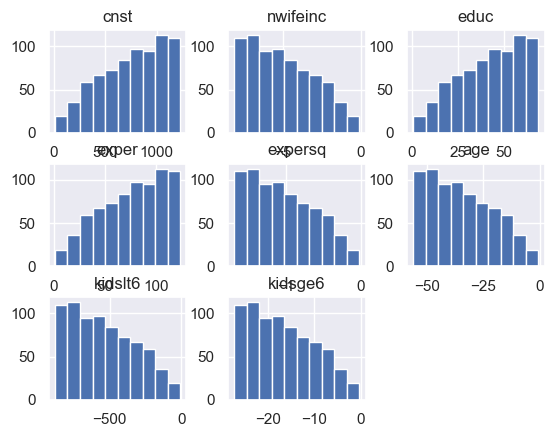

In [33]:
me2.hist()

In [34]:
# FILL IN: Plot a histogram of the marginal effect from one additional year of education from margeff_all_1
# FILL IN: Plot a histogram of the marginal effect from one additional year of education from margeff_all_2

# FILL IN: Plot a scatterplot of the marginal effect from one additional year of education from margeff_all_1
# FILL IN: Plot a scatterplot of the marginal effect from one additional year of education from margeff_all_2

In [35]:
me1

,cnst,nwifeinc,educ,exper,expersq,age,kidslt6,kidsge6
0,669.448270,-4.455797,37.538205,67.491536,-0.924288,-30.610870,-480.465785,-14.925206
1,684.334591,-4.554879,38.372931,68.992326,-0.944842,-31.291555,-491.149760,-15.257093
2,609.103544,-4.054147,34.154474,61.407783,-0.840972,-27.851576,-437.156127,-13.579833
3,669.898934,-4.458796,37.563475,67.536971,-0.924911,-30.631477,-480.789229,-14.935253
4,499.832905,-3.326850,28.027304,50.391482,-0.690105,-22.855120,-358.732138,-11.143667
...,...,...,...,...,...,...,...,...
748,509.253386,-3.389552,28.555542,51.341224,-0.703112,-23.285876,-365.493256,-11.353695
749,412.096870,-2.742885,23.107651,41.546229,-0.568971,-18.843344,-295.763624,-9.187611
750,470.882500,-3.134158,26.403958,47.472799,-0.650134,-21.531347,-337.954313,-10.498224
751,452.903237,-3.014489,25.395800,45.660190,-0.625311,-20.709236,-325.050522,-10.097381


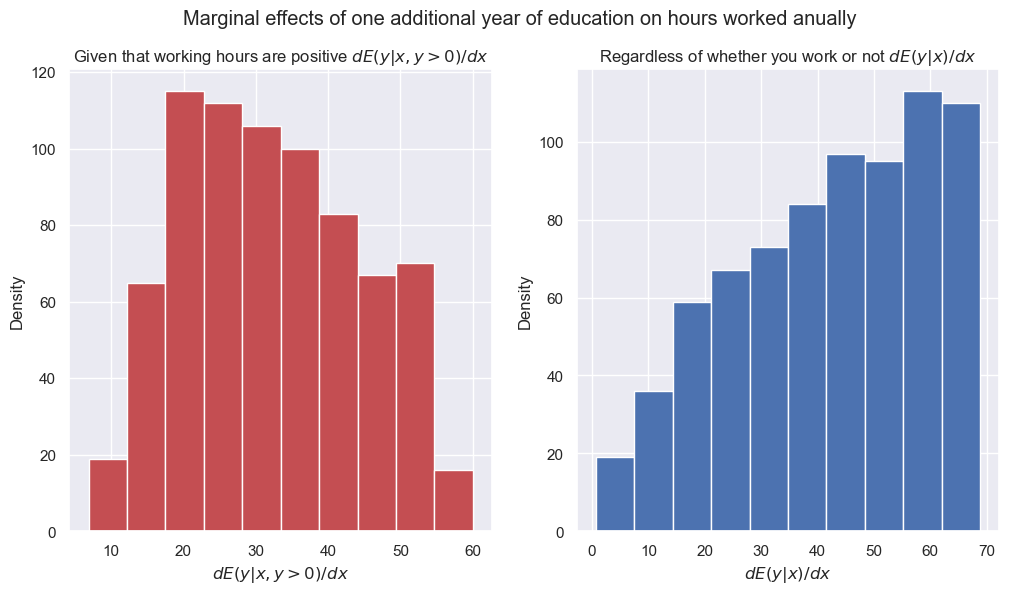

In [36]:
fig,ax = plt.subplots(1,2, figsize=(12,6));

fig.suptitle('Marginal effects of one additional year of education on hours worked anually')

ax[0].hist(me1['educ'], color='r')
ax[0].set_xlabel(r'$dE(y|x,y>0)/dx$')
ax[0].set_title(r'Given that working hours are positive $dE(y|x,y>0)/dx$')
ax[0].set_ylabel('Density')

ax[1].hist(me2['educ'])
ax[1].set_xlabel(r'$dE(y|x)/dx$')
ax[1].set_title(r'Regardless of whether you work or not $dE(y|x)/dx$')
ax[1].set_ylabel('Density')

plt.savefig('w12_fig1_tobit_margeff_educ_wrkhrs.pdf')

In [37]:
# fill in

In [38]:
# fill in

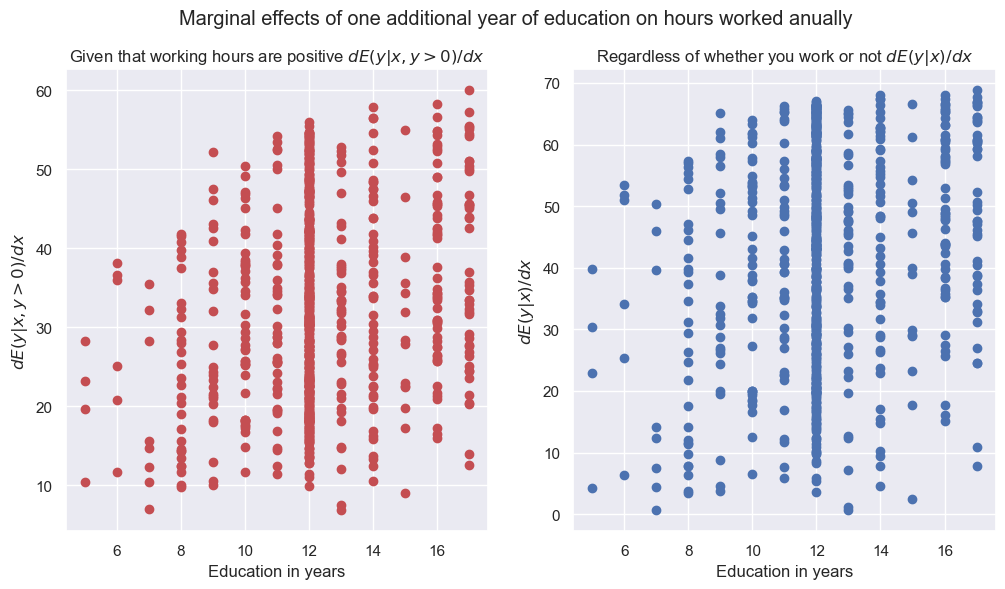

In [39]:
fig,ax = plt.subplots(1,2, figsize=(12,6));

fig.suptitle('Marginal effects of one additional year of education on hours worked anually')

ax[0].scatter(x[:, 2], me1['educ'], color='r')
ax[0].set_xlabel('Education in years')
ax[0].set_title(r'Given that working hours are positive $dE(y|x,y>0)/dx$')
ax[0].set_ylabel(r'$dE(y|x,y>0)/dx$')

ax[1].scatter(x[:, 2], me2['educ'])
ax[1].set_xlabel('Education in years')
ax[1].set_title(r'Regardless of whether you work or not $dE(y|x)/dx$')
ax[1].set_ylabel(r'$dE(y|x)/dx$')

plt.savefig('w12_fig2_tobit_margeff_educ_wrkhrs.pdf')

# Bonus: Covid example

In the following, let's switch gears and have a look at some Covid data and estimate the Tobit model there. The overarching question is: What is the effect of temperature on disease burden? Specifically, let us focus on deaths, since it does not confound testing intensity or other measures that may be different across countries. 

In [40]:
dat = pd.read_csv('covid.csv')
dat['date'] = pd.to_datetime(dat['date'])

# vaccinations are coded as missings before vaccination data collection began 
dat.people_fully_vaccinated_per_hundred = dat.people_fully_vaccinated_per_hundred.fillna(0.0)

## Descriptive

In [57]:
my_fav_country = 'Denmark' # <- change this around

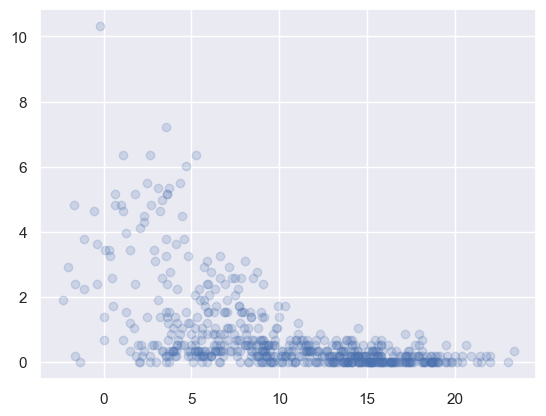

In [58]:
I = (dat.country == my_fav_country) & (dat.new_deaths_per_million >= 0.0)
plt.plot(dat[I].temperature, dat[I].new_deaths_per_million, 'o', alpha=0.2); 

## Tobit

In [59]:
yvar = 'new_deaths_per_million'
dat['const'] = 1.0 
xvars = ['const', 'temperature', 'stringency_index', 'people_fully_vaccinated_per_hundred', 'location_workplaces', 'mobility_driving']
I = (dat.country == my_fav_country) & (dat[yvar] >= 0.0) & (dat[xvars + [yvar]].notnull().all(axis=1))
y = dat.loc[I, 'new_deaths_per_million'].values
x = dat.loc[I, xvars].values

In [60]:
theta0 = tobit.starting_values(y, x)

res = estimation.estimate(tobit.q, theta0, y, x, cov_type='Outer Product', method='Nelder-Mead') #Why Nelder-Mead?

pd.DataFrame({'ols': theta0, 'theta': res['theta'], 't': res['t']}, index=xvars + ['sigma'])

Optimization terminated successfully.
         Current function value: 1.290340
         Iterations: 555
         Function evaluations: 834


,ols,theta,t
const,3.176824,4.622764,6.854191
temperature,-0.042279,-0.065919,-3.806097
stringency_index,-0.002188,-0.011334,-1.390232
people_fully_vaccinated_per_hundred,0.003107,0.006079,1.379641
location_workplaces,-0.013439,-0.014540,-4.915879
mobility_driving,-0.016825,-0.025332,-8.579016
sigma,0.989510,1.160562,48.846766


In [61]:
E,E_pos = tobit.predict(res['theta'], x)

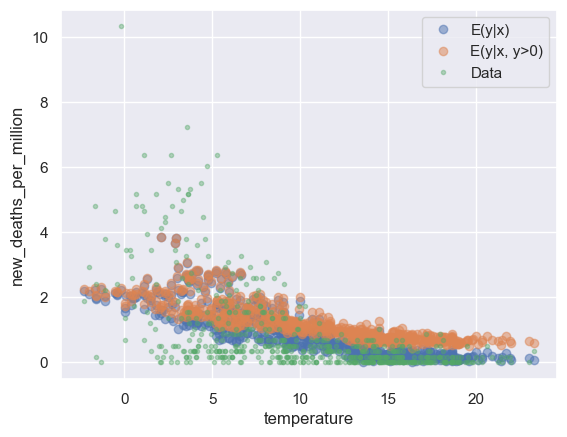

In [62]:
k = [i for i,xv in enumerate(xvars) if xv == 'temperature'][0]
fig,ax = plt.subplots(); 
ax.plot(x[:, k], E, 'o', label='E(y|x)', alpha=0.5); 
ax.plot(x[:, k], E_pos, 'o', label='E(y|x, y>0)', alpha=0.5); 
ax.plot(x[:, k], y, '.', label='Data', alpha=0.4); 
ax.set_xlabel(xvars[k]); ax.set_ylabel(yvar); 
ax.legend(); 

In [63]:
# Evaluating at the mean
x0 = np.mean(x, axis=0) # evaluate at the mean of x variables 

In [64]:
b_tob = res['theta'][:-1]
sigma_tob = res['theta'][-1]

In [65]:
margeff_pos, margeff_uncond = marg_effect(x, b_tob, sigma_tob)

In [66]:
me_pos = pd.DataFrame(margeff_pos.T, columns=xvars)
me_uncond = pd.DataFrame(margeff_uncond.T, columns=xvars)

In [67]:
me_pos

,const,temperature,stringency_index,people_fully_vaccinated_per_hundred,location_workplaces,mobility_driving
0,4.128590,-0.058872,-0.010123,0.005429,-0.012986,-0.022624
1,4.180756,-0.059616,-0.010250,0.005498,-0.013150,-0.022910
2,4.286514,-0.061124,-0.010510,0.005637,-0.013483,-0.023489
3,4.362119,-0.062202,-0.010695,0.005737,-0.013721,-0.023904
4,4.355130,-0.062102,-0.010678,0.005727,-0.013699,-0.023865
...,...,...,...,...,...,...
600,2.582363,-0.036823,-0.006331,0.003396,-0.008123,-0.014151
601,2.318127,-0.033056,-0.005684,0.003049,-0.007291,-0.012703
602,2.243809,-0.031996,-0.005501,0.002951,-0.007058,-0.012296
603,2.086383,-0.029751,-0.005115,0.002744,-0.006562,-0.011433


In [68]:
me_uncond

,const,temperature,stringency_index,people_fully_vaccinated_per_hundred,location_workplaces,mobility_driving
0,4.526435,-0.064545,-0.011098,0.005953,-0.014237,-0.024804
1,4.540715,-0.064749,-0.011133,0.005971,-0.014282,-0.024882
2,4.566884,-0.065122,-0.011197,0.006006,-0.014365,-0.025026
3,4.583292,-0.065356,-0.011237,0.006027,-0.014416,-0.025116
4,4.581857,-0.065335,-0.011234,0.006026,-0.014412,-0.025108
...,...,...,...,...,...,...
600,3.586037,-0.051135,-0.008792,0.004716,-0.011279,-0.019651
601,3.286145,-0.046859,-0.008057,0.004322,-0.010336,-0.018008
602,3.191700,-0.045512,-0.007825,0.004197,-0.010039,-0.017490
603,2.975814,-0.042434,-0.007296,0.003913,-0.009360,-0.016307


In [69]:
me_pos

,const,temperature,stringency_index,people_fully_vaccinated_per_hundred,location_workplaces,mobility_driving
0,4.128590,-0.058872,-0.010123,0.005429,-0.012986,-0.022624
1,4.180756,-0.059616,-0.010250,0.005498,-0.013150,-0.022910
2,4.286514,-0.061124,-0.010510,0.005637,-0.013483,-0.023489
3,4.362119,-0.062202,-0.010695,0.005737,-0.013721,-0.023904
4,4.355130,-0.062102,-0.010678,0.005727,-0.013699,-0.023865
...,...,...,...,...,...,...
600,2.582363,-0.036823,-0.006331,0.003396,-0.008123,-0.014151
601,2.318127,-0.033056,-0.005684,0.003049,-0.007291,-0.012703
602,2.243809,-0.031996,-0.005501,0.002951,-0.007058,-0.012296
603,2.086383,-0.029751,-0.005115,0.002744,-0.006562,-0.011433


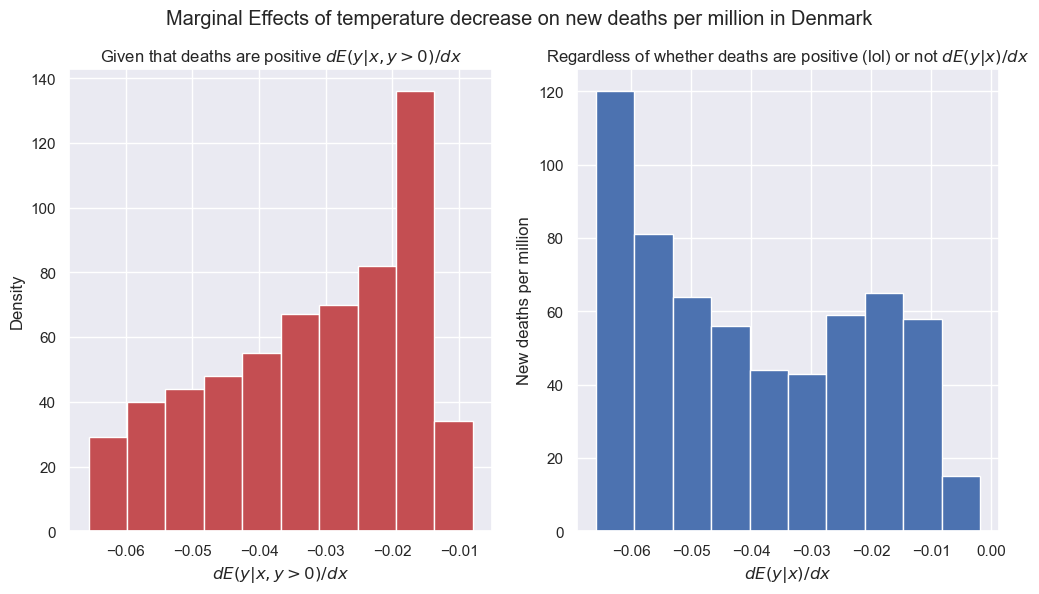

In [70]:
fig,ax = plt.subplots(1,2, figsize=(12,6));

fig.suptitle(f'Marginal Effects of temperature decrease on new deaths per million in {my_fav_country}')

ax[0].hist(me_pos['temperature'], color='r')
ax[0].set_title(r'Given that deaths are positive $dE(y|x,y>0)/dx$')
ax[0].set_ylabel('Density')
ax[0].set_xlabel(r'$dE(y|x,y>0)/dx$')

ax[1].hist(me_uncond['temperature'])
ax[1].set_title(r'Regardless of whether deaths are positive (lol) or not $dE(y|x)/dx$')
ax[1].set_ylabel('New deaths per million')
ax[1].set_xlabel(r'$dE(y|x)/dx$')

plt.savefig(f'w12_fig_tobit_covid_temperature_marg_eff1_{my_fav_country}.pdf')

In [71]:
xvars

['const',
 'temperature',
 'stringency_index',
 'people_fully_vaccinated_per_hundred',
 'location_workplaces',
 'mobility_driving']

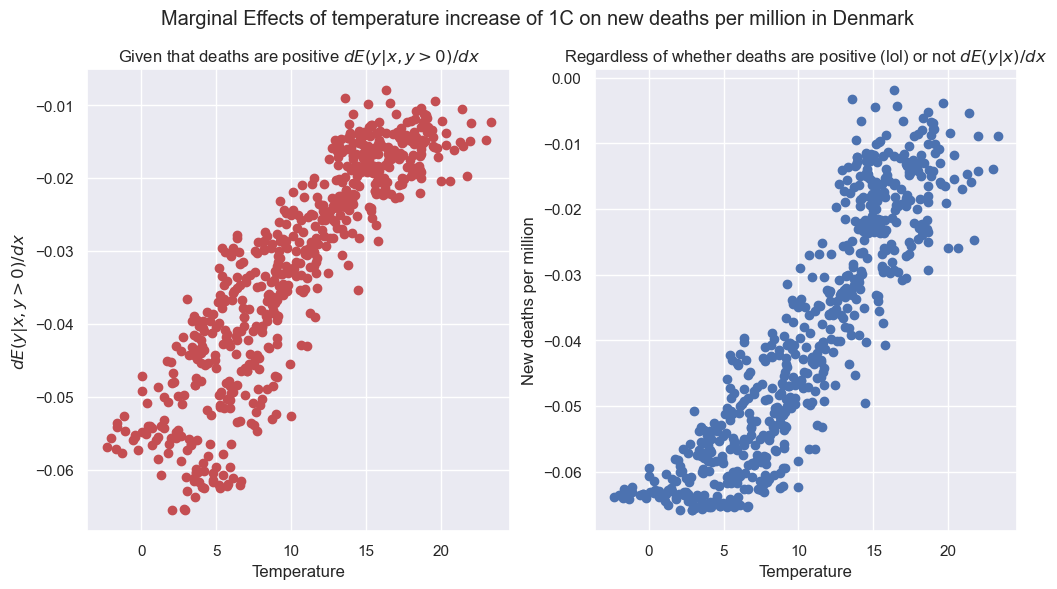

In [72]:
index_temperature = 1

fig,ax = plt.subplots(1,2, figsize=(12,6));

fig.suptitle(f'Marginal Effects of temperature increase of 1C on new deaths per million in {my_fav_country}')

ax[0].scatter(x[:, index_temperature], me_pos['temperature'], color='r')
ax[0].set_xlabel('Temperature')
ax[0].set_title(r'Given that deaths are positive $dE(y|x,y>0)/dx$')
ax[0].set_ylabel(r'$dE(y|x,y>0)/dx$')

ax[1].scatter(x[:, index_temperature], me_uncond['temperature'])
ax[1].set_xlabel('Temperature')
ax[1].set_title(r'Regardless of whether deaths are positive (lol) or not $dE(y|x)/dx$')
ax[1].set_ylabel('New deaths per million')

plt.savefig(f'w12_fig_tobit_covid_temperature_marg_eff2_{my_fav_country}.pdf')